# Advanced Machine Learning 2024/2025

##  PROJECT 1: Bayesian Networks

&copy;Helton Mendonça, nº56870 and &copy;Inês Veloso, nº56884

Supervised and evaluated by Professor Helena Aidos











### 1. Introduction
---

In this first project of the course, we are challenged in the prediction of Cardiovascular Disease risk. From common sense and international research we are aware of the importance of such topic given the ammount of resources and most importantly, lives that are lost each year due to these diseases.
For that reason, not only this type of prediction needs to be accurate but also needs to be interpretable in way that can be more trusted by the experts in the area.
Considering the last point, it makes sense to use probabilistic graphical models such as Bayesian Networks, as not only they take into account the uncertainty of the task but also are very interpretable in the sense is easy to understand the relationships between the variables.

We were given 2 datasets for this task. A training one with 3845 patients and testing one with 1282 patients.

With that, we are going to first explore the data, for some initial insight. Then we are going to build a Bayesian Network and do some analysis on the relationships of the variables, trough inference. Finally we will be conducting a classification task on the medical conditions in study.



**Disclaimer**: Along the the project we used some ChatGPT or copied/altered the professor code, especially in code debugging or to help us in stuff we did not know how to implement. But every time we do use it,  we explicitly say it. Basically we mean that everything implemented was our idea, but not necessarily done all, by us, because we are not very experienced in the coding part. With this transparancy we hope our work can be more trustful!

### 2. Data overview and exploratory analysis

---






#### 2.1 Loading the data



In [ ]:
!pip install pgmpy
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install ydata-profiling


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from IPython.display import Image, display

from ydata_profiling import ProfileReport
from numpy import where
from collections import Counter

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BDeuScore, K2Score, BicScore, PC, HillClimbSearch, MaximumLikelihoodEstimator, AICScore ,BayesianEstimator
from pgmpy.estimators.StructureScore import BDeuScore,K2Score,BicScore
from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.base import DAG

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, matthews_corrcoef

from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTEN

from IPython.display import Image, display

In [ ]:

#cardio_train = "/content/cardiovascular_train.csv" # Este só funciona até a sessão fechar, não é muito duradouro então não vale a pena usar a longo prazo

#path Helton
# cardio_train = r"/content/drive/MyDrive/coisas da faculdade/Mestrado Ciência de Dados/1ºSemestre/Machine Learning avançado/projetos/P1/P1/cardiovascular_train.csv"
# cardio_test = r"/content/drive/MyDrive/coisas da faculdade/Mestrado Ciência de Dados/1ºSemestre/Machine Learning avançado/projetos/P1/P1/cardiovascular_test.csv"

#path Inês
cardio_train = r"/content/drive/MyDrive/Trabalhos FCUL/P1/cardiovascular_train.csv"
cardio_test = r"/content/drive/MyDrive/Trabalhos FCUL/P1/cardiovascular_test.csv"




In [ ]:
#Loading of the data

df_train = pd.read_csv(cardio_train)

df_train.head()

df_test = pd.read_csv(cardio_test)

#df_test.head()



#### 2.2 Exploring the data

Here we could explore it by using only pandas, but will be using a tool Professor Cátia showed us in class, called ydata: Data Profiling (https://docs.profiling.ydata.ai/latest/).

From the documentation we can also specify we are dealing with sensitive data, so the profiling will take that into account.


In [ ]:
#Now let´s explore the data

train_profile_before_cleaning = ProfileReport(df_train,
                        title="Profiling report of Training Cardiovascular Disease Data",
                        sensitive=True)








In [ ]:
train_profile_before_cleaning


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Lets try and visualize the distribution of Diabetes, the imbalanced medical condition

# We will drop the other medical conditions briefly to only focus on the features and the Diabetes target variable:
Temp_df = df_train.drop(['Hypertension','Hypercholesterolemia'], axis= 1)


Temp_df.head(3)

,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
0,54-64,No,Overweight,No,No,2,Regularly Active,Male,6-9hours,Smoker,3
1,24-34,No,Obese,No,No,3,Regularly Active,Female,6-9hours,Non_Smoker,3
2,24-34,No,Overweight,No,No,2,Insufficiently Active,Male,6-9hours,Non_Smoker,1


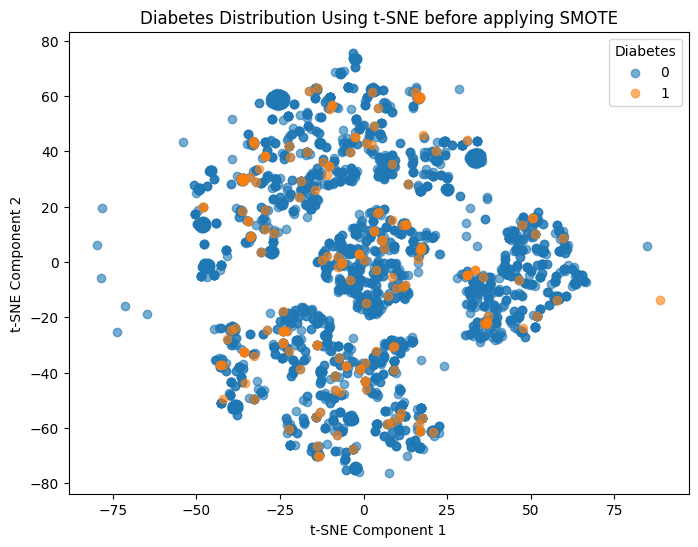

'\nDISCLAIMER: This block of code was entirely provided by ChatGPT.\n\nBasically we wanted to plot the distribution of Diabetes trough all the other features in a 2d plot similarly to what the professor showed us in TP1.\nBut we were not able to replicate it here. So we gave ChatGPT some context on the problem and the professor example code and plots.\nThen he outputed the plot below.\nHe used t-distributed Stochastic Neighbor Embedding or t-SNE, which is a statistical nonlinear dimensionality reduction technique for embedding high-dimensional data for\nvisualization in a low-dimensional space of two or three dimensions by giving each datapoint a location in the desired dimension map.[1]\n\n'

In [ ]:
# Prepare features and target variable
X = Temp_df.drop('Diabetes', axis=1)
X = pd.get_dummies(X, drop_first=True)  # Convert categorical features to numerical
y = Temp_df['Diabetes'].apply(lambda x: 1 if x == 'Yes' else 0)  # Encode target as 0 and 1

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot using t-SNE components
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    row_ix = np.where(y == label)
    plt.scatter(X_tsne[row_ix, 0], X_tsne[row_ix, 1], label=str(label), alpha=0.6)

plt.legend(title="Diabetes")
plt.title("Diabetes Distribution Using t-SNE before applying SMOTE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


'''
DISCLAIMER: This block of code was entirely provided by ChatGPT.

Basically we wanted to plot the distribution of Diabetes trough all the other features in a 2d plot similarly to what the professor showed us in TP1.
But we were not able to replicate it here. So we gave ChatGPT some context on the problem and the professor example code and plots.
Then he outputed the plot below.
He used t-distributed Stochastic Neighbor Embedding or t-SNE, which is a statistical nonlinear dimensionality reduction technique for embedding high-dimensional data for
visualization in a low-dimensional space of two or three dimensions by giving each datapoint a location in the desired dimension map.[1]

'''



#### 2.3 Discussion of the initial exploration

Analysing the automatic report, we can first observe that we are dealing with 13 variables, divided into 10 features or risk factors and 3 target variables or medical conditions, as previously known from the project statement. They are all discretized *a priori*  in a way that makes them categorical(including the boolean ones). What if it was not discretized? Could we still implement the Bayes Network? Of course, we would just need to change it to a Gaussian Bayesian Network or even a Hybrid Bayesian Network that deals with just continuos or a mix of continuos with discrete variables, respectively. But by applying a discretization trough some domain knowledge, it made the problem more simple.

Scrolling down on the report we can find the information for all the variables and we can see they have no missing,duplicated or outlier values, as the teacher affirmed in the project statement.

Checking now the Correlations Heatmap and Table we can see there are no strong direct correlations between the variables. This is because there are no correlations values over 0.5. This means, in general, the variables are not higly linearly dependent.But this does not mean they are not dependent in any other way. The Bayes Network may give us more information on that...




Now checking the report again it signals some issues regarding the imabalanced distribution of a few risk factors, like Anxiety, Depression and Sleep Duration, and one of the target variables, Diabetes. This is the medical condition the professor hints at in the project statement. Analysing the distribution plot trough t-SNE, we can visualize the disparity in the "Yes" class in orange vs the "No" class in blue. This plot is useful in noticing the overlapping of some data instances, and will be helpfull in choosing and validating a oversampling technique that try to mitigate with those class overlappings.
In the classification section we will then compare the evaluation of the prediction of the model before and after dealing with the imbalanced medical condition.

As for the testing set of data we also analysed using the same tool(we deleted it to save scrolling time). We found no issues regarding missing values, so everything was kept the same, including the imbalance issues of the variables discussed above, so it kept a more "raw" representation of the real world.





### 3. Bayesian Network Construction

---









#### 3.1 Bayes Network

A lot of times in real world scenarios, modeling can get very complex, especially when dealing with sensitive topics, like healthcare. We can tackle this issue by implementing probabilistic models, that aim to represent a joint distribution over some group of random variables. But this naive approach, can not be utilized in a general way, because, sometimes the amount of variables we may be dealing with, might make the problem extremely complicated, meaning we would need a lot of computer power, expert knowledge and a extreme volume of data to achieve meningful results.

Here enter probabilistic graphical models, that make assumptions based on conditional independences of the variables.

An illustrative example:
Let´s say we have 3 variables: $[X,Y,Z]$. $X$ and $Y$ are conditionally independent given $Z$, denoted by $X\bot Y|Z$ if and only if the conditional joint can be written as a product of marginals meaning that $X\bot Y|Z$ $≡$ $p(X,Y|Z) = p(X|Z)p(Y|Z)$

This same assumption can be extended to a Directed graphical model or a Bayesian Network. In this type of graphical model, the nodes represent random variables and the links with arrows represent the relation between variables and their causalities. This is because this network is constructed in a topological order or parent nodes before child nodes, which can be interpreted that a child node probability is "caused" by the probability of its parent(s) node(s).

Finally we can formally define the Bayesian Network, by considering the ordered Markov property, where we assume a node is conditionally independent of all its predecessors in the ordering given its parents. Then the joint distribution is given by:

$p(X) = ∏p(x_i|x_p)$

Where $X$ is a group of variables, $x_i$ is the node in study and $x_p$ are the set of parents of $x_i$[2],[3].




In [ ]:
# Initializing our model and checking our data one more time

bn = BayesianNetwork()

df_train.head()

,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
0,54-64,No,Overweight,No,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3
1,24-34,No,Obese,No,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3
2,24-34,No,Overweight,No,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1
3,34-44,No,Overweight,No,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3
4,44-54,No,Overweight,No,Yes,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3


#### 3.2 Structure and Parameter Learning

The aim of this section will be to construct the "best"  model based on the training data in our hands. Its important to have in mind, its basically impossible to find the TRUE model that represents the problem and the data we are studying. This is due to a mix of factors like the low volume of data avaiable, lack of TRUE domain expertise and even some inexperience dealing with this type of issue. Nonetheless we can think of this part as finding a low level "best" model considering our circustances.

There 2 major techniques to find the "best" structure, a constraint-based structure learning, that utilizes statistical test to infer on conditional independencies, and a score-based structure learning, that uses an optimization approach of finding the best model trough some criterion. We will be using and comparing both.

More specifically, we will be implementing PC and Hill-Climb Search from the `pgmpy` toolbox. We will not be using Exaustive search, as we believe the number of variables in this study is too large for this method to be tractable.

After getting the structure that best represents the model we must then train the model so it finds the parameters that best suit the data in order to then predict on the variables in study.


For all of this, we basically implemented 2 methods:
* First, a more eficient method of previously choosing the score and the estimator to find the best structure and parameteres, respectively.
* Second, a more naive and exaustive approach of trying multiple scores and multiple estimators and see which output a model that can better predict the diseases.

We will then compare results and justify our choices.











In [ ]:
# Defining some functions, such as, initialize_graph to define our initial graph, and visualize_network to obtain the graphs visualization

def initialize_graph(p):
  G = DAG()
  G.add_nodes_from(nodes=['Age','Anxiety','BodyMassIndex','Depression','Diabetes','EducationLevel',
            'Hypercholesterolemia','Hypertension','PhysicalActivity','Sex','SleepDuration','SmokerProfile',
            'SocioeconomicStatus'])
  init = G.get_random(n_nodes=4, edge_prob=p)
  ls = []
  mapping = {0: 'Age',1: 'Anxiety',2: 'BodyMassIndex',3: 'Depression',4: 'Diabetes',5: 'EducationLevel',
            6: 'Hypercholesterolemia',7: 'Hypertension',8: 'PhysicalActivity',9: 'Sex',10: 'SleepDuration',
            11: 'SmokerProfile',12: 'SocioeconomicStatus'}
  for i,j in init.edges:
    ls.append((mapping[i],mapping[j]))
  ls
  G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
  return G

def visualize_network(G):
  m1 = G.to_graphviz()
  img1 = m1.draw(format='png',prog="dot")
  display(Image(img1))


##### 3.2.1 Constraint Based Method

In [ ]:
#Constraint based
pc = PC(data = df_train)
best_modelPC = pc.estimate(variant="stable")
print('Best Model Edges PC: ', best_modelPC.edges())

#Scored based
bic = BicScore(df_train)
est = HillClimbSearch(data = df_train)
best_modelHCS = est.estimate(scoring_method = bic)
print('Best Model Edges HCS: ', best_modelHCS.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Best Model Edges PC:  [('SmokerProfile', 'Age'), ('Anxiety', 'Sex'), ('EducationLevel', 'SocioeconomicStatus'), ('Diabetes', 'PhysicalActivity')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Best Model Edges HCS:  [('Age', 'PhysicalActivity'), ('Anxiety', 'Sex'), ('BodyMassIndex', 'Age'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'SmokerProfile'), ('BodyMassIndex', 'SocioeconomicStatus'), ('Diabetes', 'PhysicalActivity'), ('Hypertension', 'Hypercholesterolemia'), ('PhysicalActivity', 'Hypertension'), ('Sex', 'PhysicalActivity'), ('SmokerProfile', 'Age'), ('SmokerProfile', 'Hypercholesterolemia')]


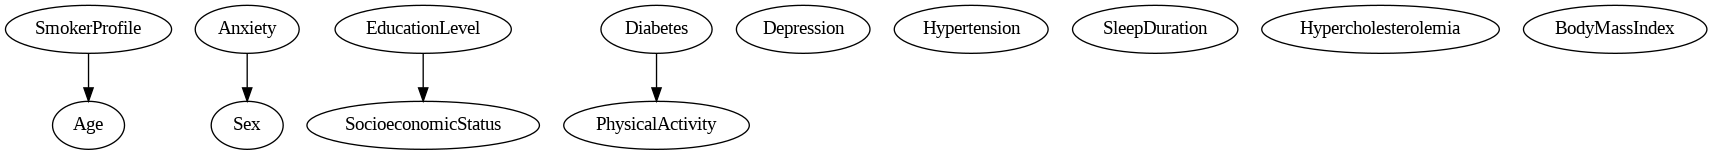

In [ ]:
#Graph with the constraint method
m1 = best_modelPC.to_graphviz()
img1 = m1.draw(format='png',prog="dot")
display(Image(img1))

Here we see this graph is too simple and could not capture the nuances of the relations between the variables. Its to be expected as the sample number in this dataset is quite small. This constraint method best performs when dealing with a lot of volume of data and some prior domain expertise. So it confirmed what was learned in the theoretical classes.


##### 3.2.2 Eficient Model selection Method

When we say eficient method, we are only talking about the time domain. Its obvious that when we learn and train one model vs several it will take less time. But does that mean we get a better model? Thats what we also tried to study.

For this method we used the information learned in class. Considering that we are dealing with sensitive data, that we have a low volume of data disposable and the high dimensionality of the dataset, we decided to choose a score method to find the best strucure. As we seen previously the constraint based was not robust enough to handle the issues we are dealing with. Exaustive Search, we didnt even try because considering we have 13 variables, the total number of graphs in the possible graph domain would be extreme and would need too much computer power. We could of tried Chow-Liu algorithm, as his main goal is just to maximize the log-likelihood of the tree-structured graph. But this method does not penalize graphs structures, so we decided to invest in the Greedy-Hill-Climbing algorithm, that does small changes to an initial graph iteratively and calculates the score for each, settling on the one that yields the best result. For which score tough? Using a MaximumLikelihood score could lead to the graph with best evaluation metrics but we know its a method that once again does not penalize more complex structures so it often overfits to the data, possibly even converging to a fully conected one.
So we believed a Bayesian Score would be more suitable, as it takes into account  uncertainty of the model to the data while trying to penalize more complex models. For this reason we decided to choose BDeu score, that not only does the above but also acts with "prior" knowledge between the variables being studied. Meaning it takes into account bias and relationships between the variables. Though its a minor role, considering the sensitive data, we thought that it was a justified use. Knowing this, we of could also have used K2, but as discussed in the classes K2 tends to be inconsistent.



For the reasons similar to the above, we also used BDeu for the parameter estimation.


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/583 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/569 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/568 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/549 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/536 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/534 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/505 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/521 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

<ipython-input-10-9688d0bf9d21>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-10-9688d0bf9d21>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)


Results for Diabetes:
  Average Accuracy: 0.9542
  Average Recall: 0.0000
  Average Precision: 0.0000
  Average F1 Score: 0.0000

Results for Hypertension:
  Average Accuracy: 0.8120
  Average Recall: 0.1112
  Average Precision: 0.5911
  Average F1 Score: 0.1827

Results for Hypercholesterolemia:
  Average Accuracy: 0.6635
  Average Recall: 0.3333
  Average Precision: 0.6289
  Average F1 Score: 0.4345

Number of Edges:  20


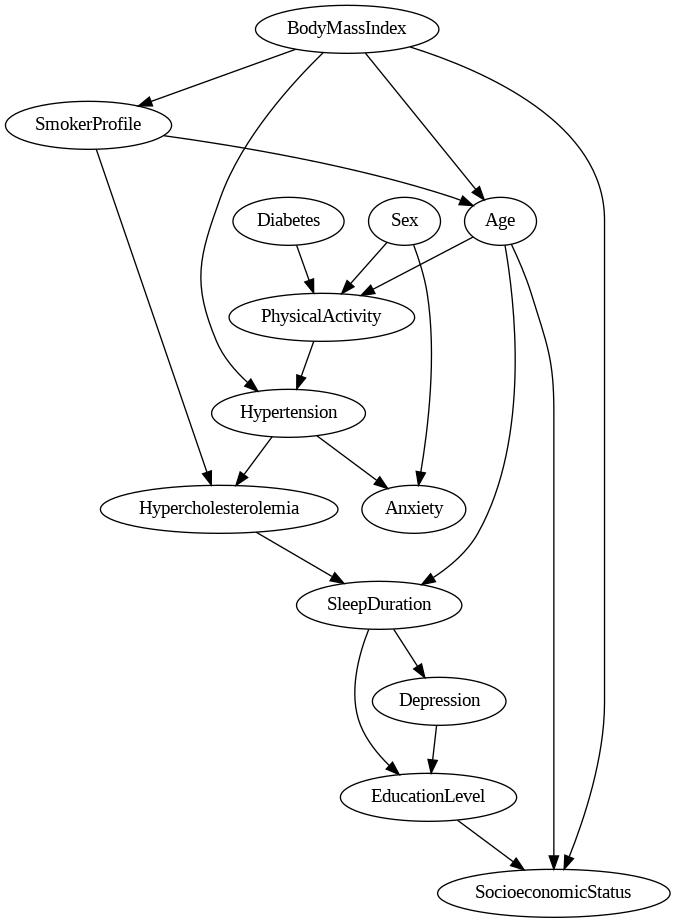

'\nDISCLAIMER: We used ChatGPT to get a more clean look to this block of code and for it too work 100% well but the idea was ours.\n\n'

In [ ]:
# Lets try and build a model without forcing every single possible model with HillClimbSearch

skf = StratifiedKFold(n_splits=5,shuffle=False)

# Training and validating for the imbalanced disease using K-fold

diseases = ['Diabetes', 'Hypertension','Hypercholesterolemia']
results = {'Diabetes' : [], 'Hypertension' : [], 'Hypercholesterolemia' : []}


for d in diseases:

  for train_index, test_index in skf.split(df_train, df_train[d]):


      train_data = df_train.iloc[train_index]
      test_data = df_train.iloc[test_index]

      G = initialize_graph(0.0)

      hcs = HillClimbSearch(train_data)
      best_model_structure = hcs.estimate(scoring_method=BDeuScore(train_data), start_dag=G)

      best_model_structure = BayesianNetwork(best_model_structure)
      best_model_structure.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

      best_model_structure.check_model()


      predictions = best_model_structure.predict(test_data.drop(columns=[d]))
      predictions = predictions.replace({'Yes': 1, 'No': 0}).astype(int)

      true_values = test_data[d]
      true_values = true_values.replace({'Yes': 1, 'No': 0}).astype(int)

      accuracy = accuracy_score(true_values, predictions)
      recall = recall_score(true_values, predictions)
      precision = precision_score(true_values, predictions)
      f1 = f1_score(true_values, predictions)

      results[d].append([accuracy, recall, precision, f1])


# Obtaining the statistics for each disease

for d in diseases:
    avg_results = np.mean(results[d], axis=0)
    print(f"Results for {d}:")
    print(f"  Average Accuracy: {avg_results[0]:.4f}")
    print(f"  Average Recall: {avg_results[1]:.4f}")
    print(f"  Average Precision: {avg_results[2]:.4f}")
    print(f"  Average F1 Score: {avg_results[3]:.4f}\n")

print('Number of Edges: ',len(best_model_structure.edges()))
visualize_network(best_model_structure)

'''
DISCLAIMER: We used ChatGPT to get a more clean look to this block of code and for it too work 100% well but the idea was ours.

'''

In [ ]:


avg_acc = 0
avg_recall = 0
avg_precision = 0
avg_f1 = 0

for key,value in results.items():
  avg_disease_metrics = np.mean(value, axis=0)

  avg_acc += avg_disease_metrics[0]
  avg_recall += avg_disease_metrics[1]
  avg_precision += avg_disease_metrics[2]
  avg_f1 += avg_disease_metrics[3]


num_diseases = len(results)
avg_acc /= num_diseases
avg_recall /= num_diseases
avg_precision /= num_diseases
avg_f1 /= num_diseases

print('Average Accuracy Overall :',avg_acc)
print('Average Recall Overall :',avg_recall)
print('Average Precision Overall :',avg_precision)
print('Average F1 Score Overall :',avg_f1)

Average Accuracy Overall : 0.809882964889467
Average Recall Overall : 0.14818786479547663
Average Precision Overall : 0.40666426792544647
Average F1 Score Overall : 0.20571823447907853


14


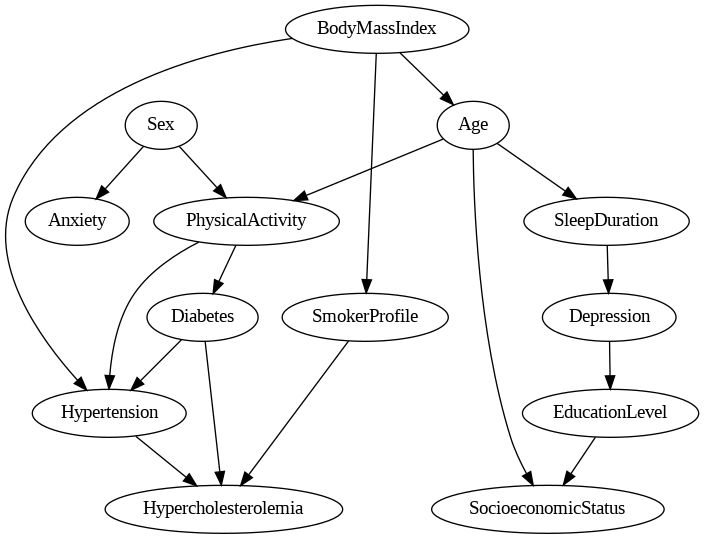

True

In [ ]:
# Copying the model structure so that what we change in the links doesn't affect the original model

best_model_structure2 = copy.deepcopy(best_model_structure)

# Deleting links:
#best_model_structure2.remove_edge('SleepDuration','Age')                       # Age will affect Sleep Duration and not the other way aroung
#best_model_structure2.remove_edge('Anxiety','Sex')                             # From statistics we know that Anxiety is more common in females than in men
#best_model_structure2.remove_edge('Depression','Sex')                          # From statistics we know that Depression is more common in females than in men
best_model_structure2.remove_edge('BodyMassIndex','SocioeconomicStatus')        # BodyMassIndex doesn't affect SocioeconomicStatus, it's more likely that SocioeconomicStatus affects BodyMassIndex
best_model_structure2.remove_edge('Diabetes','PhysicalActivity')                # Diabetes doesn't lead to PhysicalActivity, but the lack of PhysicalActivity can lead to Diabetes
best_model_structure2.remove_edge('Hypercholesterolemia','SleepDuration')       # A Disease can not cause an risk factor directly
best_model_structure2.remove_edge('SmokerProfile','Age')                        # Age is not caused by any variable, is static
best_model_structure2.remove_edge('Hypertension','Anxiety')                     # Does not make much sense a physiological disease impact an mental disease
best_model_structure2.remove_edge('SleepDuration','EducationLevel')             # Does not make much sense a physiological disease impact an mental disease
#best_model_structure2.remove_edge('Hypercholesterolemia','Sex')                # Depending on the Age, it's more commom for certain gender to have Hypercholesterolemia

print(len(best_model_structure2.edges()))

# And by adding links that make absolute sense considering some domain expertise (but bias)
best_model_structure2.add_edge('Diabetes', 'Hypertension')                      # From research we know that Diabetes can lead to Hypertension and Hypercholesterolemia
best_model_structure2.add_edge('Diabetes', 'Hypercholesterolemia')
best_model_structure2.add_edge('PhysicalActivity', 'Diabetes')                  # Like justified preiviously
best_model_structure2.add_edge('Age','SleepDuration')                           # As said before, Age will affect SleepDuration

visualize_network(best_model_structure2)

# Now re-fitting to update the cpds

best_model_structure2.fit(df_train, estimator=BayesianEstimator, prior_type='BDeu')
best_model_structure2.check_model()

Above, we used Stratified K-fold method to find a model that outputed better results in a more robust way, than just simply dividing the data into training and validation, especially given the fact we have small data. We used this technique specifically because we are dealing with an imbalanced class and from what we learned in the first class of the semester, this is a good cross-validation technique to deal with that type of issue in the data. However even when using random state we obtained random results, so we decided on not using shuffle, to obtain more stable results, that aren't as robust, since it would be problematic altering the bayesian model every time we run the code.

After training and validating we see that the model gets pretty bad results predicting the validation sets for the diseases. Especially with Diabetes, that gets null recall, precision and f1 score, but a great accuracy (~95%). This is due to the imbalanced nature of that target variable, that "tricks" the model into thinking is correctly predicting the classes when it reality its totally corrupted.
In general we believe this all comes down to the low volume of data avaiable to train this model.

But a positive takeway is the simplicity of the graph outputed. While most likely not the TRUE model its a very simple one and fast to train. Even when deleting and adding some links, the model kept its simplicity and interpretability. This was too be expected due to the methods we use to learn and train the model, as discussed previously. As sugested by the professor we decided not too change the graph by hand in a extreme way, only by deleting non-sense links and adding a few necessary ones, in our bias opinion.

This part could only really be done by a group of TRUE experts in the fields, such as Cardiovascular Medical Doctors.



##### 3.2.3 Iterative Search Method

This method was done only as a comparison to the previous one. The reasoning was that believed that it would be very unlikely for us to find the best learning and training pipelines that outputed the best results. Especially just by running one model vs many.

The catch is that this method is way more expensive computanionally to implement and most likely would still not lead us to the TRUE best model, due to negative factors mentioned previously like the lack of data, for example.

So we believe that this is not the correct way of selecting Bayesian Network in a true real world job or research.

In [ ]:
# Data organization: Defining our Xdata and ydata to train our model
Xdata = df_train.drop(['Diabetes', 'Hypertension', 'Hypercholesterolemia'], axis=1)
ydata = df_train[['Hypertension', 'Diabetes', 'Hypercholesterolemia']]

# Splitting the training data for training and validation in the iterative method
X_train, X_val, y_train, y_val = train_test_split(Xdata, ydata, test_size=0.33, random_state=0)

# Splittitng the medical conditions in y_train, so that we can get the statistics
y_train_hyp = y_train['Hypertension']
y_train_diab = y_train['Diabetes']
y_train_hypchol = y_train['Hypercholesterolemia']

y_val_hyp = y_val['Hypertension']
y_val_diab = y_val['Diabetes']
y_val_hypchol = y_val['Hypercholesterolemia']

# Converting 'Yes'/'No' to 1/0
y_val_hyp_binary = y_val_hyp.replace({'Yes': 1, 'No': 0}).astype(int)
y_val_diab_binary = y_val_diab.replace({'Yes': 1, 'No': 0}).astype(int)
y_val_hypchol_binary = y_val_hypchol.replace({'Yes': 1, 'No': 0}).astype(int)

<ipython-input-13-dd85c13326fb>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val_hyp_binary = y_val_hyp.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-13-dd85c13326fb>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val_diab_binary = y_val_diab.replace({'Yes': 1, 'No': 0}).astype(int)
<ipython-input-13-dd85c13326fb>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in 

In [ ]:
# Doing an Iterative Search to obtain the best graph

bdeu = BDeuScore(df_train, equivalent_sample_size=5)
aic = AICScore(df_train)
k2 = K2Score(df_train)
bic = BicScore(df_train)
p_scores = [0.0, 0.5, 0.9] # Empty graph, Half-Linked, Almost fully linked

scores = [bdeu, aic, k2, bic]
saved_models = []
hcs = HillClimbSearch(df_train)

for i in scores:
  for p in p_scores:
    G = initialize_graph(p)
    model = hcs.estimate(scoring_method=i, start_dag=G)
    model = BayesianNetwork(model)
    model.fit(df_train, estimator=BayesianEstimator, prior_type= 'BDeu')
    model.check_model()

    # se fizermos predict so a partir das variaveis observadas ou X_val o predict da o resultado para todas as variaveis nao observadas de uma vez, nos queremos apenas uma de cada vez
    predicted_test_hyp = model.predict(X_val)['Hypertension']
    predicted_test_hyp = predicted_test_hyp.values
    predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})

    predicted_test_diab = model.predict(X_val)['Diabetes']
    predicted_test_diab = predicted_test_diab.values
    predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})

    predicted_test_hypchol = model.predict(X_val)['Hypercholesterolemia']
    predicted_test_hypchol = predicted_test_hypchol.values
    predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})

    # Statitics for hyperthesion
    accuracy_hyp = accuracy_score(y_val_hyp_binary, predicted_test_hyp_binary)
    recall_hyp = recall_score(y_val_hyp_binary, predicted_test_hyp_binary)
    precision_hyp = precision_score(y_val_hyp_binary, predicted_test_hyp_binary)
    f1score_hyp = f1_score(y_val_hyp_binary, predicted_test_hyp_binary)

    # Statitics for Diabetes, the imbalanced target
    accuracy_diab = accuracy_score(y_val_diab_binary, predicted_test_diab_binary)
    recall_diab = recall_score(y_val_diab_binary, predicted_test_diab_binary)
    precision_diab = precision_score(y_val_diab_binary, predicted_test_diab_binary)
    f1score_diab = f1_score(y_val_diab_binary, predicted_test_diab_binary)

    # Statitics for Hypercholesterolemia
    accuracy_hypchol = accuracy_score(y_val_hypchol_binary, predicted_test_hypchol_binary)
    recall_hypchol = recall_score(y_val_hypchol_binary, predicted_test_hypchol_binary)
    precision_hypchol = precision_score(y_val_hypchol_binary, predicted_test_hypchol_binary)
    f1score_hypchol = f1_score(y_val_hypchol_binary, predicted_test_hypchol_binary)

    accs = [accuracy_hyp, accuracy_diab, accuracy_hypchol]
    recalls = [recall_hyp, recall_diab, recall_hypchol]
    precisions = [precision_hyp, precision_diab, precision_hypchol]
    f1scores = [f1score_hyp, f1score_diab, f1score_hypchol]

    saved_models.append([model,p,i, accs, recalls, precisions, f1scores])
    print(f'Hypertension: \n ---------------\n P value: {p}\n Score type: {i} \n Model Score: {i.score(model)}\n Accuracy: {accuracy_hyp}\n Recall: {recall_hyp}\n Precision: {precision_hyp}\n F1 Score: {f1score_hyp}\n ***********************\n ')
    print(f'Diabetes(Imabalenced): \n ---------------\n P value: {p}\n Score type: {i} \n Model Score: {i.score(model)}\n Accuracy: {accuracy_diab}\n Recall: {recall_diab}\n Precision: {precision_diab}\n F1 Score: {f1score_diab}\n ***********************\n ')
    print(f'Hypercholesterolemia: \n ---------------\n P value: {p}\n Score type: {i} \n Model Score: {i.score(model)}\n Accuracy: {accuracy_hypchol}\n Recall: {recall_hypchol}\n Precision: {precision_hypchol}\n F1 Score: {f1score_hypchol}\n ***********************\n')



  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

Hypertension: 
 ---------------
 P value: 0.0
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31648.04150102543
 Accuracy: 0.806146572104019
 Recall: 0.028455284552845527
 Precision: 0.5
 F1 Score: 0.05384615384615385
 ***********************
 
Diabetes(Imabalenced): 
 ---------------
 P value: 0.0
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31648.04150102543
 Accuracy: 0.9479905437352246
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Hypercholesterolemia: 
 ---------------
 P value: 0.0
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31648.04150102543
 Accuracy: 0.628053585500394
 Recall: 0.14078674948240166
 Precision: 0.544
 F1 Score: 0.2236842105263158
 ***********************



<ipython-input-19-bdc8999080e3>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

Hypertension: 
 ---------------
 P value: 0.5
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31646.46797103726
 Accuracy: 0.806146572104019
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Diabetes(Imabalenced): 
 ---------------
 P value: 0.5
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31646.46797103726
 Accuracy: 0.9479905437352246
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Hypercholesterolemia: 
 ---------------
 P value: 0.5
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31646.46797103726
 Accuracy: 0.6201733648542159
 Recall: 0.016563146997929608
 Precision: 0.5333333333333333
 F1 Score: 0.0321285140562249
 ***********************



<ipython-input-19-bdc8999080e3>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

Hypertension: 
 ---------------
 P value: 0.9
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31646.46797103726
 Accuracy: 0.806146572104019
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Diabetes(Imabalenced): 
 ---------------
 P value: 0.9
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31646.46797103726
 Accuracy: 0.9479905437352246
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Hypercholesterolemia: 
 ---------------
 P value: 0.9
 Score type: <pgmpy.estimators.StructureScore.BDeuScore object at 0x7e35216f3730> 
 Model Score: -31646.46797103726
 Accuracy: 0.6201733648542159
 Recall: 0.016563146997929608
 Precision: 0.5333333333333333
 F1 Score: 0.0321285140562249
 ***********************



<ipython-input-19-bdc8999080e3>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

Hypertension: 
 ---------------
 P value: 0.0
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30964.64587447172
 Accuracy: 0.8037825059101655
 Recall: 0.052845528455284556
 Precision: 0.4482758620689655
 F1 Score: 0.09454545454545454
 ***********************
 
Diabetes(Imabalenced): 
 ---------------
 P value: 0.0
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30964.64587447172
 Accuracy: 0.9479905437352246
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Hypercholesterolemia: 
 ---------------
 P value: 0.0
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30964.64587447172
 Accuracy: 0.6516942474389283
 Recall: 0.2505175983436853
 Precision: 0.6019900497512438
 F1 Score: 0.3538011695906433
 ***********************



<ipython-input-19-bdc8999080e3>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

Hypertension: 
 ---------------
 P value: 0.5
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30922.780990855896
 Accuracy: 0.8077226162332545
 Recall: 0.044715447154471545
 Precision: 0.55
 F1 Score: 0.08270676691729323
 ***********************
 
Diabetes(Imabalenced): 
 ---------------
 P value: 0.5
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30922.780990855896
 Accuracy: 0.9479905437352246
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Hypercholesterolemia: 
 ---------------
 P value: 0.5
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30922.780990855896
 Accuracy: 0.6493301812450749
 Recall: 0.2567287784679089
 Precision: 0.5904761904761905
 F1 Score: 0.3578643578643579
 ***********************



<ipython-input-19-bdc8999080e3>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hypertension: 
 ---------------
 P value: 0.9
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30912.503710906403
 Accuracy: 0.8029944838455477
 Recall: 0.07317073170731707
 Precision: 0.45
 F1 Score: 0.1258741258741259
 ***********************
 
Diabetes(Imabalenced): 
 ---------------
 P value: 0.9
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30912.503710906403
 Accuracy: 0.9479905437352246
 Recall: 0.0
 Precision: 0.0
 F1 Score: 0.0
 ***********************
 
Hypercholesterolemia: 
 ---------------
 P value: 0.9
 Score type: <pgmpy.estimators.StructureScore.AICScore object at 0x7e35216f3790> 
 Model Score: -30912.503710906403
 Accuracy: 0.6509062253743105
 Recall: 0.2525879917184265
 Precision: 0.5980392156862745
 F1 Score: 0.3551673944687045
 ***********************



  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

<ipython-input-19-bdc8999080e3>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})


  0%|          | 0/601 [00:00<?, ?it/s]

In [ ]:
def abordagem_2(model):

    # se fizermos predict so a partir das variaveis observadas ou X_val o predict da o resultado para todas as variaveis nao observadas de uma vez, nos queremos apenas uma de cada vez
    predicted_test_hyp = model.predict(X_val)['Hypertension']
    predicted_test_hyp = predicted_test_hyp.values
    predicted_test_hyp_binary = pd.Series(predicted_test_hyp).replace({'Yes': 1, 'No': 0})

    predicted_test_diab = model.predict(X_val)['Diabetes']
    predicted_test_diab = predicted_test_diab.values
    predicted_test_diab_binary = pd.Series(predicted_test_diab).replace({'Yes': 1, 'No': 0})

    predicted_test_hypchol = model.predict(X_val)['Hypercholesterolemia']
    predicted_test_hypchol = predicted_test_hypchol.values
    predicted_test_hypchol_binary = pd.Series(predicted_test_hypchol).replace({'Yes': 1, 'No': 0})

    # Metricas para hyperthesion
    accuracy_hyp = accuracy_score(y_val_hyp_binary, predicted_test_hyp_binary)
    recall_hyp = recall_score(y_val_hyp_binary, predicted_test_hyp_binary)
    precision_hyp = precision_score(y_val_hyp_binary, predicted_test_hyp_binary)
    f1score_hyp = f1_score(y_val_hyp_binary, predicted_test_hyp_binary)

    #Metricss para Diabetes, the imbalanced target
    accuracy_diab = accuracy_score(y_val_diab_binary, predicted_test_diab_binary)
    recall_diab = recall_score(y_val_diab_binary, predicted_test_diab_binary)
    precision_diab = precision_score(y_val_diab_binary, predicted_test_diab_binary)
    f1score_diab = f1_score(y_val_diab_binary, predicted_test_diab_binary)

    # Metricas para Hypercholesterolemia
    accuracy_hypchol = accuracy_score(y_val_hypchol_binary, predicted_test_hypchol_binary)
    recall_hypchol = recall_score(y_val_hypchol_binary, predicted_test_hypchol_binary)
    precision_hypchol = precision_score(y_val_hypchol_binary, predicted_test_hypchol_binary)
    f1score_hypchol = f1_score(y_val_hypchol_binary, predicted_test_hypchol_binary)

    accuracys = [accuracy_hyp, accuracy_diab, accuracy_hypchol]
    recalls = [recall_hyp, recall_diab, recall_hypchol]
    precisions = [precision_hyp, precision_diab, precision_hypchol]
    f1scores = [f1score_hyp, f1score_diab, f1score_hypchol]

    best_accuracy_average = sum(accuracys)/ len(accuracys)
    print(f'Best Model explanation:\n-----------------------\n')
    print(f'Best Accuracy Average: {best_accuracy_average}')

    best_recall_average = sum(recalls)/ len(recalls)
    print(f'Best Model explanation:\n-----------------------\n')
    print(f'Best Recall Average: {best_recall_average}')

    best_precision_average = sum(precisions)/ len(precisions)
    print(f'Best Model explanation:\n-----------------------\n')
    print(f'Best Precision Average: {best_precision_average}')


    best_f1_average = sum(f1scores)/len(f1scores)
    print(f'Best Model explanation:\n-----------------------\n')
    print(f'Best F1 Score Average: {best_f1_average}')

    return None


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges:  [('Age', 'BodyMassIndex'), ('Age', 'SmokerProfile'), ('Age', 'PhysicalActivity'), ('Age', 'SocioeconomicStatus'), ('Age', 'Hypercholesterolemia'), ('Anxiety', 'BodyMassIndex'), ('Anxiety', 'Sex'), ('Anxiety', 'SmokerProfile'), ('Anxiety', 'SocioeconomicStatus'), ('Depression', 'BodyMassIndex'), ('Depression', 'SmokerProfile'), ('Depression', 'SocioeconomicStatus'), ('Diabetes', 'BodyMassIndex'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'SmokerProfile'), ('Diabetes', 'SocioeconomicStatus'), ('Diabetes', 'Hypercholesterolemia'), ('Diabetes', 'Hypertension'), ('EducationLevel', 'BodyMassIndex'), ('EducationLevel', 'SmokerProfile'), ('EducationLevel', 'SocioeconomicStatus'), ('Hypercholesterolemia', 'BodyMassIndex'), ('Hypercholesterolemia', 'SmokerProfile'), ('Hypercholesterolemia', 'SocioeconomicStatus'), ('Hypercholesterolemia', 'Hypertension'), ('Hypertension', 'BodyMassIndex'), ('Hypertension', 'SmokerProfile'), ('Hypertension', 'SocioeconomicStatus'), ('PhysicalActivity

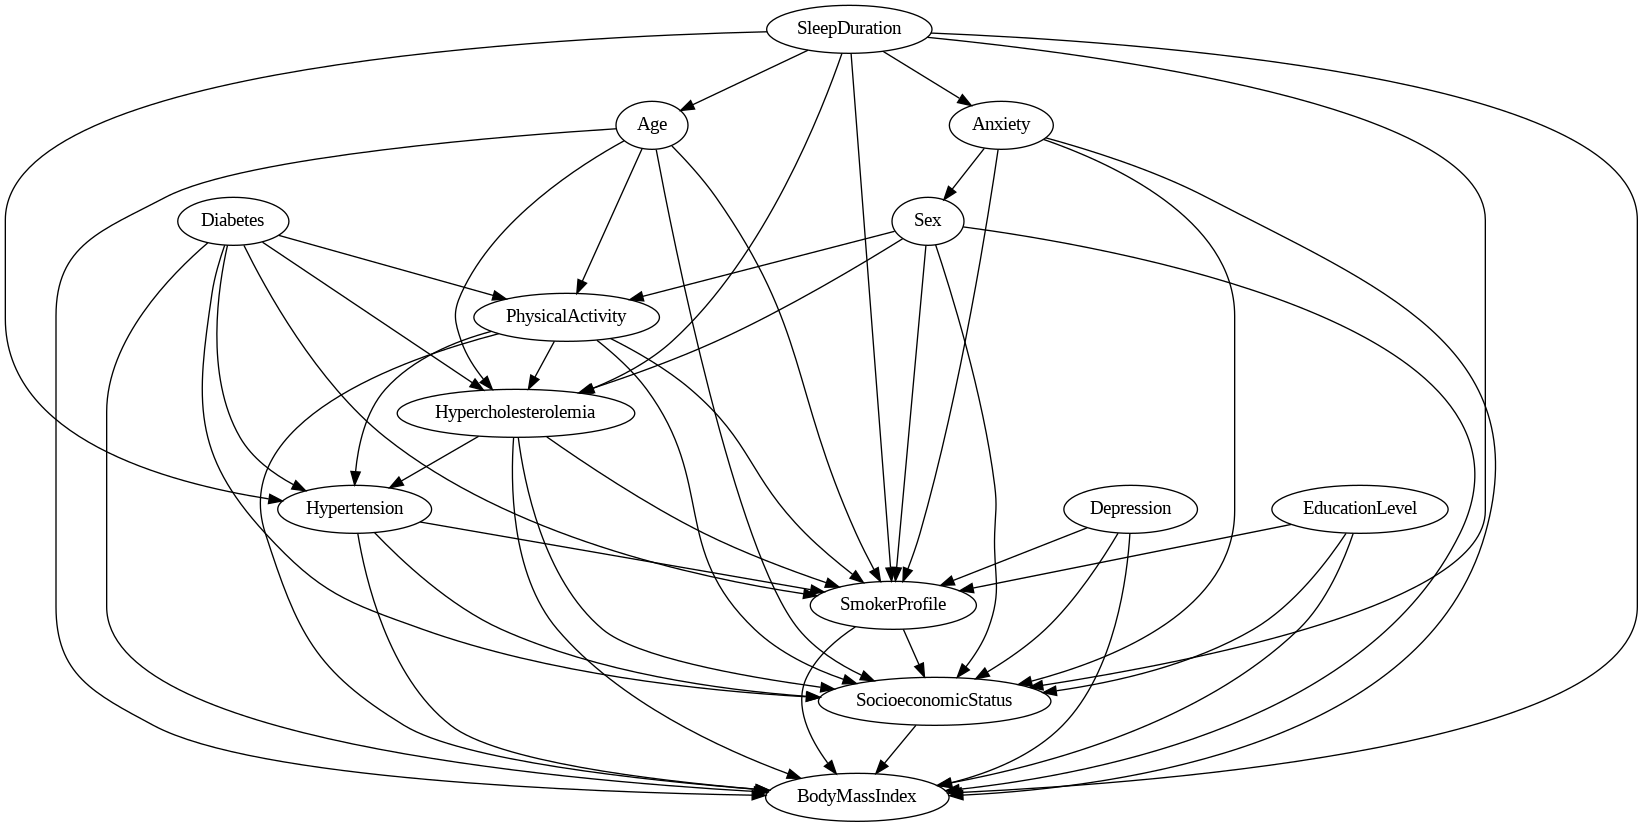

In [ ]:
#Bayesian estimator with Bdeu prior

k2 = K2Score(df_train)
hcs = HillClimbSearch(df_train)

G = initialize_graph(0.0)
best_model_bdeu = hcs.estimate(scoring_method= k2, start_dag=G)
best_model_bdeu = BayesianNetwork(best_model_bdeu)
best_model_bdeu.fit(df_train, estimator=BayesianEstimator, prior_type = 'BDeu')
best_model_bdeu.check_model()

print('Edges: ',best_model_bdeu.edges())
print('How Many Edges: ',len(best_model_bdeu.edges()))



After analysing all the Bayesian Networks for different p and score values, we came to the conclusion that the "best" model, used k2score, a p-value = 0 and a BDeu prior estimator for parameteres(MLE estimator had roughly the same results ). With this features we obtained the best recall, f1score and precision.

Is this a better model than the one obtained in 3.2.2? From a evaluation metrics only, point of view, definitly. But then, when the graph it self is evaluated we see how extremely complex it is, with a total of 48 edges. This way of searching the "best model" only took into consideration the evaluation metrics, meaning how well the model could predict the diseases, and did not consider simpler models with possibly slightly worse results. Because of this exagerated complexity we believe this model is not better than the previous one, because it would need much more editing by ourselves or a group of experts, for it to be truly representative of the problem. Not only that, with a model this complex it would not scale well in the case we got acess to more data to train it, so it justifies our claims above that this is not a pratical nor inteligent way of selecting a Bayesian Network in the real world.



##### **Final Decision and considerations on the model chosen**


So considering the above, the obtained model from 3.2.2, will be the final model structure and parameters. We believe it is simple, has good enough interpretation of the real world while being able to have decent metrics of validation, considering the extremely low volume of data and the imbalanced nature of some variables.







### 4. Network Analysis
---
In this section we implemented Variable Elimination, an exact inference technique to get more insight on the relationships between the variables.
Here we saw how choosing a more simple structure model was beneficial as it enabled the use of exact inference, that tends to be intractable for more complex graph structures.

For learning purposes, and considering once again we are dealing with sensitive and uncertain by nature problem, we also tried to implement approximate inference techniques like Gibbs Sampling and Variational Inference. The issue arised in getting results from them.

Gibbs sampling creates samples from the network and tries to  estimate the probability of the event of interest.
Now considering this network is much more complex than the ones analysed in class, this presented as a challenge, as the sampling of just 1000 points started to take too long to compute, and we were not even certain it would converge to the desired value. Because of it we decided to not go any further on that.

With Variational Inference, we were just experimenting on the question of, "What if we didn´t have all the variables at our disposal?". Meaning we would be dealing with a latent variable problem. Along with it, we learned that this is a emergent technique that deals with issues such as little data and uncertainty, two issues we are dealing in this project(possibly in the real world as well). Though this method was a good candidate, we could not implement it, neither based from the professor code in the TP class nor a python library that helps doing it, like `pymc` (https://www.pymc.io/projects/docs/en/stable/api/vi.html) or `tensorflow` (https://www.tensorflow.org/probability/examples/Variational_Inference_and_Joint_Distributions). We believe this is due not only the complexity of this method but also our inexperience in dealing with these libraries and this problem in general.
So we end up not getting any results from it.

Nonetheless this served as learning opportunity for us, that may be explored in the future.




In [ ]:
# from pgmpy.sampling.Sampling import GibbsSampling

# gibbs_chain = GibbsSampling(best_model)
# df_train = gibbs_chain.sample(size=10**3, seed=45)

# d = df_train[df_train['Age']==0]
# ne = d['Age'].count() # number of samples matching the evidence
# print('number of samples matching the evidence:', ne)
# nv = d[d['SleepDuration']==0]['SleepDuration'].count()
# print('number of samples matching the desired values:', nv)
# print('estimated probability:',nv/ne)

# p = []
# x = range(10,1000,50)
# for i in x:
#   dd=df_train[:i]
#   d = dd[dd['Age']==0]
#   ne = d['Age'].count() # number of samples matching the evidence
#   nv = d[d['SleepDuration']==0]['SleepDuration'].count() # number of samples matching the desired values
#   p.append(nv/ne)
# plt.plot(x,p)
# plt.show()

In [ ]:
# import pymc as pm
# import numpy as np

# # Assume `best_model` is a BayesianNetwork object with learned structure and parameters
# # It should have a method or attribute to extract conditional probabilities, e.g., CPTs.


# # Extract CPD for 'Age' (prior probability table)
# age_cpd = best_model.get_cpds('Age')  # Ensure 'Age' exists as a variable in the Bayesian Network
# age_probs = age_cpd.values  # Extract the probability distribution for 'Age'

# # print(age_cpd)
# # print(age_probs)


# # Extract CPD for 'SleepDuration' (conditional probability table P(SleepDuration | Age))
# sleep_duration_cpd = best_model.get_cpds('SleepDuration')  # Ensure the variable exists in the model
# sleep_probs_given_age = sleep_duration_cpd.values  # This will be a 2D array for P(SleepDuration | Age)

# print(sleep_duration_cpd)
# print(sleep_probs_given_age)

# # Define the PyMC model
# with pm.Model() as model:
#       # Use age_probs as the prior for 'Age'
#     age = pm.Categorical('Age', p=age_probs, observed=df_train['Age'])

#     # Use sleep_probs_given_age for P(SleepDuration | Age)
#     sleep_duration = pm.Categorical(
#         'SleepDuration', p = sleep_probs_given_age[age],
#         observed=None  # Leave it as latent for analysis
#     )

#     # Perform variational inference
#     approx = pm.fit(n=10000, method='advi')

# # Analyze the posterior
# with model:
#     posterior_samples = approx.sample(500)

# # Posterior analysis (as before)
# import arviz as az

# idata = az.from_pymc(posterior=posterior_samples)
# print(az.summary(idata, var_names=['SleepDuration']))



#### 4.1 How age affects sleep duration

From our bias opinion we would expect that the relationship between age and sleep duration is not linear. Even though the hours of sleep a person needs is the same after 18 years, around 8 hours, some other factors influence the hours someone sleeps. From the ages from '18-24' to '34-44' a person may sleep less to university/work, social life, small kids, etc. From the ages '44-54' a person might sleep more than the previous ones,  since at this age a person, normally, no longer needs to take care of babies/children, and may live a less chaotic life, which allows them to sleep more. For the ages '64-74' a person may sleep less due to some other factors like: sleep disorder, chronic medical condition, undiagnosed mood disorder, or side effects of medications.


In [ ]:
ages= {'18-24','24-34', '34-44', '44-54', '54-64', '64-74'}

for j in ages:
  inference = VariableElimination(best_model_structure2)
  print('\n', 'Sleep Duration Inference for Ages between', j)
  P = inference.query(variables=['SleepDuration'], evidence= {'Age': j})
  print(P)


 Sleep Duration Inference for Ages between 18-24
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.9807 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.0096 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0096 |
+-------------------------+----------------------+

 Sleep Duration Inference for Ages between 54-64
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8343 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1652 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0005 |
+-------------------------+------



From the inference analysis, in general, we can affirm that all age groups sleep more around the recomended sleep duration of around 6-9 hours.

But we can also see some evidence that contradicts our prior assumptions, like younger people, around '18-24' to '34-44' sleeping less. We see that those groups have smaller probabilities of sleeping less than the other groups.
This means that the assumption of more middle age people, like '44-54' to '54-64' sleeping more might also be wrong, as we can see they have a lower probability of sleeeping around 6-9 hours and a higher probabilty of sleeping <6 hours.

A positive assumption, seems to be that older people tend to sleep less, and we can see that in the analysis, where they have higher probability of sleeping <6 hours, compared to much younger age groups.

#### 4.2 How SmokerProfile affects the three medical conditions

When analysing how the Smoker Profile affects the three medical conditions we would expect that it would affect the three of them.


*   **Smoker Profile and Diabetes**: Smoking is one of the possible causes of type 2 diabetes. From our research we found that people who smoke cigarettes are more likely to develop type 2 diabetes than people who don't smoke. [4]
*   **Smoker Profile and Hypertension**: Smoking is considered a risk factor to aggravate Hypertension, but we did not found much evidence on directly causing it. So it could have an equal impact on all SmokerProfiles, because of the lack of direct causality. [5]
*   **Smoker Profile and Hypercholesterolemia**: Smoking is also a risk factor for Hypercholesterolemia, since smokers usually have a higher values of LDL and lower values of HDL, which contribute to Hypercholesterolemia. [6]



In [ ]:
SmoPro= {'Non_Smoker', 'Ex_Smoker', 'Smoker'}
medicalconditions = {'Hypertension', 'Diabetes', 'Hypercholesterolemia'}


for i in medicalconditions:
  for j in SmoPro:
    inference = VariableElimination(best_model_structure2)
    print( i, 'Inference for SmokerProfile =', j)
    P = inference.query(variables= [i], evidence= {'SmokerProfile': j})
    print(P, '\n', '\n')

Hypercholesterolemia Inference for SmokerProfile = Non_Smoker
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.6520 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.3480 |
+---------------------------+-----------------------------+ 
 

Hypercholesterolemia Inference for SmokerProfile = Smoker
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.5609 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.4391 |
+---------------------------+-----------------------------+ 
 

Hypercholesterolemia Inference f

When analysing the results on how Diabetes is affected by the Smoker Profile, we weren't able to obtain the expected values, probably due to the fact that we have an extremely unbalanced sample for diabetes, to the negative class. Because of it the model thinks that no matter the risk a person will have always a low probability of having Diabetes. We can not infer on nothing in this case.

Considering Hypertension, we see that it has equal probabilities across all smoker profiles. As we previously mentioned we could not found evidence on direct causality, so this might justify our prior assumption.

Finally, for Hypercholesterolemia, we see that for a Non smoker, it will have less probability of having this disease compared to the other profiles.

Now its important again to note that we are dealing with some issues in our data like the ones previously mentioned in the project. Along side that, what is really an "Ex_Smoker" in this study? For how long have they been clean? Stopping the addiction 10 years ago is not the same as stopping a few weeks or months ago. We would see more damage on those more recently stopped smoking. Or even for Smokers, how long have they've been smoking? Same rationale. Smoking for 10 years vs few weeks or months is not the same, so it will have different impact on the body.

These are domain specific considerations to have when doing these type of analysis.




#### 4.3 How BodyMassIndex affects the three medical conditions

When analysing how body mass index affects the three medical conditions our assumptions aren't that certain, since BMI clearly can affect the three medical conditions but there exists other factors that need to be taken in account, since BMI does not take into account the type of mass (Body Fat or Skeleton Muscle mass) and it doesn't take into account were is the extra mass being stored at (Android and Gynoid).For example:

*   Diabetes and BMI: The more excess weight you have, the more resistant your muscle and tissue cells become to your own insulin hormone. However, Many studies have demonstrated that android fat may be the driving force behind increased cardiovascular disease development and progression to diabetes. [7]

*   Hypertension and BMI: Studies found that the prevalence of hypertension increases with rising BMI, through by promoting insulin resistance and leptin resistance, by increased procoagulatory activity and by endothelial dysfunction, and via other systems. However a study also found a correlation between low muscle mass and hypertension. Lastly, android fat deposition can be a risk for cardiovascular diseases, therefore, this is also a factor that should be taken into account. [8][9][10]


*   Hypercholesterolemia and BMI: For hypercholesterolemia studies found a direct relationship between increasing BMI and raised LDL-C and an inverse correlation with HDL-C, which indicates hypercholesterolemia. However this is not the biggest cause of this disease, since it can be due to genetic causes, diabetes or hypertension.[11][12]



In [ ]:
BMI= {'Underweight', 'Normal', 'Obese', 'Overweight'}
medicalconditions = {'Hypertension', 'Diabetes', 'Hypercholesterolemia'}


for i in medicalconditions:
  for j in BMI:
    inference = VariableElimination(best_model_structure2)
    print( i, 'Inference for BMI =', j)
    P = inference.query(variables= [i], evidence= {'BodyMassIndex': j})
    print(P, '\n', '\n')

Hypercholesterolemia Inference for BMI = Underweight
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.5515 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.4485 |
+---------------------------+-----------------------------+ 
 

Hypercholesterolemia Inference for BMI = Overweight
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.6230 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.3770 |
+---------------------------+-----------------------------+ 
 

Hypercholesterolemia Inference for BMI = Obese


When analysing the probabilities obtained we came to the following conclusions:

Regarding hypercholesterolemia, we verified that the higher probability of having this condition happened when the person was underweight or obese, while the probabilty of having hypercholesterolemia was more or less the same for normal and overweight people. This could be due to the fact that the main factor that causes hypercholesterolemia isn't the weight, and there are other risk factors. Maybe we would get more linear results if we infered the probabilty of having hypercholesterolemia given that the person has diabetes and/or hypertension. We could also add another class, for family history, since this is one of the main causes.

For diabetes the results are all, almost the same, like the previous exercise, we can't draw too many conclusions from the results as the data is extremely unbalanced, and the results will not be representative of  the real world data.

For the hypertension, the results indicate that a person underweight and obese is more likely to have hypertension than a normal and overweight person. Theoretically the results are not as we expected, since we expected for a linear trend.

With this being said, we could have obtained better results, maybe if we used a better model, chose other parameters, or did a more exhaustive search. However like previously said, we didn't have a large dataset, and especially for diabetes, didn't have many people with that disease. And if we had other variables that represented better our medical diseases, or that explained some of the variables of our dataset we could've had better results. Some of them would be: Years Smoking; Years since stopped Smoking; If the family members had diabetes/hypertension/hypercholesterolemia; type of obesity (Android or Gynoid); Skeletal muscle mass, etc.

All of these shows the prevalence that domain knowledge has in ML aplication and analysis.

#### 4.4 How Hypertension affects Hypercholesterolemia

After our discussion in the previous section we decided to analyse the correlation between hypertension and hypercholesterolemia, we didn't analyse the correlation with diabetes, since, as previously said, the class is highly unbalanced and wouldn't represent the real world statistics.

What we expected for this section is that the probabilty of having hypercholesterolemia would be higher if the person had hypertension.

In [ ]:
hypertension = {'Yes', 'No'}

for i in hypertension:
  inference = VariableElimination(best_model_structure2)
  print('Hypercholesterolemia Inference for Hypertension =', i)
  P = inference.query(variables= ['Hypercholesterolemia'], evidence= {'Hypertension': i})
  print(P, '\n', '\n')

Hypercholesterolemia Inference for Hypertension = No
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.6686 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.3314 |
+---------------------------+-----------------------------+ 
 

Hypercholesterolemia Inference for Hypertension = Yes
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+=============================+
| Hypercholesterolemia(No)  |                      0.3697 |
+---------------------------+-----------------------------+
| Hypercholesterolemia(Yes) |                      0.6303 |
+---------------------------+-----------------------------+ 
 



The results were exactly as we predicted. We can see that there is a higher probability of having hypercholesterolemia if the person has hypertension, and there's a lower probability of not having hypercholesterolemia if the person doesn't have hypertension.

### 5. Classification of medical conditions

---

Here we will be implementing testing metrics like the ones used previously in validation, plus Matthews Correlation Coeficient(MCC). This metric is a bit more robust in classification evaluation because it not only takes into consideration the proportion of False Positives, False Negatives, True Positives and True Negatives, but also the sizes of these 4 cases, in the confusion matrix. This particular carachteristic of MCC comes in handy when dealing with imbalanced target variables in our datasets, as its our case. A MCC score close to 0, means a prediction not much better than a random one. A MCC closer to 1 means a better prediction and a MCC closer to -1 means a worse prediction.

These will be applied before and after applying SMOTEN,with a smapling strategy of 1, meaning the minority and majority class will have a 50/50 split. This a oversampling technique that deals with categorical data type, as in our case. Note that not only we were considering this implementation, we were thinking on more advanced and specific tecniques like BorderlineSMOTE or ADASYN, that deal with more tricky areas of the instance space, where the majority and minority class instances are either extremely close or even overlapping.

But we could not implement those using sklearn, even when trying with the help of ChatGPT. We believe this is due to the categorical nature of our data, along with our inexperience. We believe they could yield slightly better results, based on the dispersion graph found in section 2. Exploratory Data Analysis.


In [ ]:
def get_stats(test, preds):
  accuracy = accuracy_score(test, preds)
  recall = recall_score(test, preds)
  precision = precision_score(test, preds)
  f1score = f1_score(test, preds)
  mcc = matthews_corrcoef(test, preds)
  confusion = confusion_matrix(test, preds)

  return print(f'Accuracy: {accuracy:.2f}', '\n', f'Recall: {recall:.2f}', '\n', f'Precision: {precision:.2f}', '\n', f'f1-Score: {f1score:.2f}', '\n', "Matthews Correlation Coefficient:", mcc, '\n', "Matriz de Confusão:", '\n', confusion, '\n')


In [ ]:
# Preparing the data for predicting the diseases

X_test = df_test.drop(['Diabetes', 'Hypertension', 'Hypercholesterolemia'], axis=1)
y_test = df_test[['Hypertension', 'Diabetes', 'Hypercholesterolemia']]

y_test_hyp = y_test['Hypertension'].replace({'Yes': 1, 'No': 0})
y_test_diab = y_test['Diabetes'].replace({'Yes': 1, 'No': 0})
y_test_hypchol = y_test['Hypercholesterolemia'].replace({'Yes': 1, 'No': 0})

preds_hyp = best_model_structure2.predict(X_test)['Hypertension']
preds_hyp = preds_hyp.replace({'Yes': 1, 'No': 0})
preds_diab = best_model_structure2.predict(X_test)['Diabetes']
preds_diab = preds_diab.replace({'Yes': 1, 'No': 0})
preds_hypchol = best_model_structure2.predict(X_test)['Hypercholesterolemia']
preds_hypchol = preds_hypchol.replace({'Yes': 1, 'No': 0})

<ipython-input-27-deb82c635ca6>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_hyp = y_test['Hypertension'].replace({'Yes': 1, 'No': 0})
<ipython-input-27-deb82c635ca6>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_diab = y_test['Diabetes'].replace({'Yes': 1, 'No': 0})
<ipython-input-27-deb82c635ca6>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beh

  0%|          | 0/591 [00:00<?, ?it/s]

<ipython-input-27-deb82c635ca6>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_hyp = preds_hyp.replace({'Yes': 1, 'No': 0})


  0%|          | 0/591 [00:00<?, ?it/s]

<ipython-input-27-deb82c635ca6>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_diab = preds_diab.replace({'Yes': 1, 'No': 0})


  0%|          | 0/591 [00:00<?, ?it/s]

<ipython-input-27-deb82c635ca6>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_hypchol = preds_hypchol.replace({'Yes': 1, 'No': 0})


In [ ]:
print('Hypertension: \n')
get_stats(y_test_hyp, preds_hyp)
print('Diabetes: \n')
get_stats(y_test_diab, preds_diab)
print('Hypercholesterolemia: \n')
get_stats(y_test_hypchol, preds_hypchol)

Hypertension: 

Accuracy: 0.82 
 Recall: 0.02 
 Precision: 0.57 
 f1-Score: 0.03 
 Matthews Correlation Coefficient: 0.07570419309384865 
 Matriz de Confusão: 
 [[1049    3]
 [ 226    4]] 

Diabetes: 

Accuracy: 0.95 
 Recall: 0.00 
 Precision: 0.00 
 f1-Score: 0.00 
 Matthews Correlation Coefficient: 0.0 
 Matriz de Confusão: 
 [[1224    0]
 [  58    0]] 

Hypercholesterolemia: 

Accuracy: 0.62 
 Recall: 0.02 
 Precision: 0.60 
 f1-Score: 0.05 
 Matthews Correlation Coefficient: 0.05709450142609546 
 Matriz de Confusão: 
 [[787   8]
 [475  12]] 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Applying Smote


In [ ]:
X = df_train.drop(['Diabetes'], axis=1)
y_diab = df_train['Diabetes']

sm = SMOTEN(sampling_strategy=1, random_state=42)
X_res, y_res = sm.fit_resample(X, y_diab)

resampled_data = X_res.copy()
resampled_data['Diabetes'] = y_res

# Fit the model with the resampled data for Diabetes
best_model_structure2.fit(data=resampled_data, estimator=BayesianEstimator, prior_type = 'Bdeu')

y_test_diab = df_test['Diabetes']
y_test_hyp = df_test['Hypertension']
y_test_hypchol = df_test['Hypercholesterolemia']

X_test = df_test.drop(['Diabetes','Hypertension','Hypercholesterolemia'], axis=1)

y_test_diab = y_test_diab.replace({'Yes': 1, 'No': 0})
y_test_hyp = y_test_hyp.replace({'Yes': 1, 'No': 0})
y_test_hypchol = y_test_hypchol.replace({'Yes': 1, 'No': 0})

preds_diab = best_model_structure2.predict(X_test)['Diabetes']
preds_diab = preds_diab.replace({'Yes': 1, 'No': 0})

preds_hyp = best_model_structure2.predict(X_test)['Hypertension']
preds_hyp = preds_hyp.replace({'Yes': 1, 'No': 0})

preds_hypchol = best_model_structure2.predict(X_test)['Hypercholesterolemia']
preds_hypchol = preds_hypchol.replace({'Yes': 1, 'No': 0})


print('Diabetes: \n')
get_stats(y_test_diab, preds_diab)
print('Hypertension: \n')
get_stats(y_test_hyp, preds_hyp)
print('Hypercholesterolemia: \n')
get_stats(y_test_hypchol, preds_hypchol)

<ipython-input-25-04239bc7b133>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_diab = y_test_diab.replace({'Yes': 1, 'No': 0})
<ipython-input-25-04239bc7b133>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_hyp = y_test_hyp.replace({'Yes': 1, 'No': 0})
<ipython-input-25-04239bc7b133>:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.se

  0%|          | 0/591 [00:00<?, ?it/s]

<ipython-input-25-04239bc7b133>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_diab = preds_diab.replace({'Yes': 1, 'No': 0})


  0%|          | 0/591 [00:00<?, ?it/s]

<ipython-input-25-04239bc7b133>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_hyp = preds_hyp.replace({'Yes': 1, 'No': 0})


  0%|          | 0/591 [00:00<?, ?it/s]

Diabetes: 

Accuracy: 0.74 
 Recall: 0.43 
 Precision: 0.08 
 f1-Score: 0.13 
 Matthews Correlation Coefficient: 0.08883243691341579 
 Matriz de Confusão: 
 [[924 300]
 [ 33  25]] 

Hypertension: 

Accuracy: 0.81 
 Recall: 0.01 
 Precision: 0.18 
 f1-Score: 0.02 
 Matthews Correlation Coefficient: -0.0008872345851216113 
 Matriz de Confusão: 
 [[1038   14]
 [ 227    3]] 

Hypercholesterolemia: 

Accuracy: 0.61 
 Recall: 0.01 
 Precision: 0.21 
 f1-Score: 0.01 
 Matthews Correlation Coefficient: -0.03584900577137815 
 Matriz de Confusão: 
 [[784  11]
 [484   3]] 



<ipython-input-25-04239bc7b133>:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_hypchol = preds_hypchol.replace({'Yes': 1, 'No': 0})


From the analysis of the results before and after applying SMOTEN we can see that for the Diabetes prediction the results improved. Especially in recall , going from null to 0.43. When it comes to the other metrics, like precision and f1, they improved but not as much.


For all the other diseases studied, they're results actually worsen in general, especially when it comes down to precision. We are not 100% what could of caused this, but we suspect the model is simply not good nor robust enough. Maybe the imbalance in Diabetes, overshadowed the poor results in the other classes.

This is mostly dued to the lack of data avaiable for training. Just like in a real world scenario, having more data is not easy, so we must improve our methods so that we make even more robust models. Our inexperience may of played a role on that.



### 6. Conclusions
---
In this project we were able to build a Bayesian Network, from the dataset provided by the professor. From it, we sucessufully implemented some network analysis, trough inference. Finally we concluded with the prediction of the diseases at study before and after dealing with the imbalance issue.

On a positive note, we used knowledge from the theoretical classes to construct the Bayesian Netwwork in a more efficient way. That method, provided a model that was simple and somewhat interpretable and realistic. Though we are aware that is still not the "best" possible model, we are content with its structure, and with some TRUE domain knowledge and possibly more data, we believe that our method would of resulted in a better model.

On a less positive side, we must be realistic with ourselves, on the fact that this is simply not a good enough model to predict these diseases. As previously mentioned in the Introduction, this topic expects high quality results, and we did not deliver to those standards. This can be attributed to issues outside of our control like the lack of data once again, but we also believe we could of optimized even more the results, had we had more experience in this type of problems.

Nonetheless, the challenges faced in this project, not only made it more interesting and insightfull, also served as indicator and lesson for future endeavors in the real world application of Machine Learning.




### References



[1] Hinton, Geoffrey; Roweis, Sam (January 2002). Stochastic neighbor embedding (PDF). Neural Information Processing Systems.

[2] Murphy, K.P. (2023). Probabilistic Machine Learning: Advanced Topics. The MIT Press

[3] Bishop, C.M. (2006). Pattern Recognition and Machine Learning. Springer

[4] Maddatu J, Anderson-Baucum E, Evans-Molina C. Smoking and the risk of type 2 diabetes. Transl Res. 2017 Jun;184:101-107. doi: 10.1016/j.trsl.2017.02.004. Epub 2017 Mar 6. PMID: 28336465; PMCID: PMC5429867.

[5] Virdis A, Giannarelli C, Neves MF, Taddei S, Ghiadoni L. Cigarette smoking and hypertension. Curr Pharm Des. 2010;16(23):2518-25. doi: 10.2174/138161210792062920. PMID: 20550499.

[6] Nakamura M, Yamamoto Y, Imaoka W, Kuroshima T, Toragai R, Ito Y, Kanda E, J Schaefer E, Ai M. Relationships between Smoking Status, Cardiovascular Risk Factors, and Lipoproteins in a Large Japanese Population. J Atheroscler Thromb. 2021 Sep 1;28(9):942-953. doi: 10.5551/jat.56838. Epub 2020 Oct 28. PMID: 33116031; PMCID: PMC8532056.

[7] Sari CI, Eikelis N, Head GA, Schlaich M, Meikle P, Lambert G, Lambert E. Android Fat Deposition and Its Association With Cardiovascular Risk Factors in Overweight Young Males. Front Physiol. 2019 Sep 18;10:1162. doi: 10.3389/fphys.2019.01162. PMID: 31620011; PMCID: PMC6759693.

[8] Krzysztof Narkiewicz, Obesity and hypertension—the issue is more complex than we thought, Nephrology Dialysis Transplantation, Volume 21, Issue 2, February 2006, Pages 264–267, https://doi.org/10.1093/ndt/gfi290

[9] Luo JH, Zhang TM, Yang LL, Cai YY, Yang Y. Association between relative muscle strength and hypertension in middle-aged and older Chinese adults. BMC Public Health. 2023 Oct 25;23(1):2087. doi: 10.1186/s12889-023-17007-6. PMID: 37880652; PMCID: PMC10598916.

[10] Sari CI, Eikelis N, Head GA, Schlaich M, Meikle P, Lambert G, Lambert E. Android Fat Deposition and Its Association With Cardiovascular Risk Factors in Overweight Young Males. Front Physiol. 2019 Sep 18;10:1162. doi: 10.3389/fphys.2019.01162. PMID: 31620011; PMCID: PMC6759693.

[11] Hussain A, Ali I, Kaleem WA, Yasmeen F. Correlation between Body Mass Index and Lipid Profile in patients with Type 2 Diabetes attending a tertiary care hospital in Peshawar. Pak J Med Sci. 2019;35(3):591-597. doi: 10.12669/pjms.35.3.7. PMID: 31258559; PMCID: PMC6572993.

[12] Ibrahim MA, Asuka E, Jialal I. Hypercholesterolemia. [Updated 2023 Apr 23]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2024 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK459188/



